In [1]:
WEB_SITE_NAME = 'Academicfiles.ir'
TEST_SET_SIZE = 0.999 # max = 1
TEST_SET_SIZE1 = 0.999 # max = 1

In [2]:
WEB_SITE_matrix = '../../models/' + WEB_SITE_NAME + '/view_matrix/lil_matrix.npz'
WEB_SITE_content_CSV = '../../models/content/' + WEB_SITE_NAME + '.csv'
WEB_SITE_itemindexer = '../../models/' + WEB_SITE_NAME + '/view_matrix/item_indexer.indexer'
WEB_SITE_userindexer = '../../models/' + WEB_SITE_NAME + '/view_matrix/user_indexer.indexer'
SAVING1 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_item_indexer_factorized.indexer'
SAVING2 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_user_indexer_factorized.indexer'
SAVING3 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_items_vectors.npy'
SAVING4 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_users_vectors.npy'
RESULTS = '../results/popBias/' + WEB_SITE_NAME + '/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix
import scipy
import scipy.sparse
import itertools
import random

In [4]:
WEBSITE_content = pd.read_csv(WEB_SITE_content_CSV)
WEBSITE_content.head(20)

,Unnamed: 0,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,subdomain_id,title_vector,image_id,cats,features_extracted,page_identifier
0,0,8475174,2020-12-01 18:35:04.867656+03:30,"{0.181003868579865,-0.985709011554718,-0.20928...",جزوه ایمونولوژی و واکسن,academicfiles.ir/downloads/%D8%AC%D8%B2%D9%88%...,296,t,f,t,t,286,"{-0.418062120676041,-0.864031434059143,-0.8326...",40256.0,{},f,47283245
1,1,8475175,2020-12-01 18:35:04.870556+03:30,"{0.593344807624817,-0.655299663543701,-1.20981...",جزوه آناتومی اندام قسمت تحتانی,academicfiles.ir/downloads/%D8%AC%D8%B2%D9%88%...,296,t,f,t,t,286,"{-0.202281668782234,-1.5898859500885,-2.787350...",40256.0,{},f,47284341
2,3,8475214,2020-12-01 18:40:04.956007+03:30,"{0.153946578502655,-0.571563422679901,1.252807...",تئوری حسابداری 1 و 2 مهرانی و کرمی -,academicfiles.ir/downloads/tag/%D8%AA%D8%A6%D9...,296,t,f,t,t,286,"{0.91486257314682,-0.677540957927704,1.1033498...",3147404.0,{11},f,47285246
3,4,8475215,2020-12-01 18:40:04.958774+03:30,"{-0.911576867103577,-0.977785766124725,-0.2590...",جزوه کامل حسابداری مالیاتی,academicfiles.ir/downloads/%D8%AC%D8%B2%D9%88%...,296,t,f,t,t,286,"{-2.85880398750305,-1.90469288825989,-0.181052...",40256.0,{},f,47286187
4,9,8475301,2020-12-01 18:50:04.721226+03:30,"{-0.693304598331451,-0.187729254364967,-0.2123...",جزوه اقتصاد و جامعه Economy and Society اثر ما...,academicfiles.ir/downloads/%D8%AC%D8%B2%D9%88%...,296,t,f,t,t,286,"{-1.35367345809937,-0.0481835529208183,-0.6105...",40256.0,{},f,47288738
5,11,8475340,2020-12-01 18:55:04.789803+03:30,"{-0.329988479614258,-1.34687232971191,1.424980...",نظریه های حسابرسی -,academicfiles.ir/downloads/tag/%D9%86%D8%B8%D8...,296,t,f,t,t,286,"{-0.626194000244141,-2.52449584007263,1.084055...",3147404.0,{},f,47290592
6,15,8475456,2020-12-01 19:10:04.992985+03:30,"{-1.01103484630585,-0.749025166034698,-0.29550...",جزوه روش تحقیق در عملیات,academicfiles.ir/downloads/%D8%AC%D8%B2%D9%88%...,296,t,f,t,t,286,"{-4.16677045822144,-1.41018378734589,-2.045444...",40256.0,{},f,47297435
7,16,8475457,2020-12-01 19:10:04.994089+03:30,"{0.0375135317444801,-2.29875254631042,0.153778...",سیستمهای اطلاعات مدیریت پیشرفته -,academicfiles.ir/downloads/tag/%D8%B3%DB%8C%D8...,296,t,f,t,t,286,"{0.389095515012741,-1.80867493152618,-0.003519...",3147404.0,{26},f,47297491
8,20,8475568,2020-12-01 19:20:07.543669+03:30,"{-0.19298081099987,-0.829504549503326,-0.17550...",جزوه روش های رسمی در مهندسی نرم افزار,academicfiles.ir/downloads/%D8%AC%D8%B2%D9%88%...,296,t,f,t,t,286,"{-1.72945523262024,-1.24553525447845,-0.730428...",40256.0,{28},f,47300541
9,27,8475679,2020-12-01 19:30:04.842541+03:30,"{-0.356924474239349,-0.773107171058655,0.43395...",کتاب معماری کامپیوتر موریس مانو و حل المسائل,academicfiles.ir/downloads/%DA%A9%D8%AA%D8%A7%...,296,t,f,t,t,286,"{-0.497492164373398,-1.00441813468933,0.467795...",292365.0,{},f,47303836


In [5]:
WEBSITE_content = WEBSITE_content[WEBSITE_content.included == 't']
WEBSITE_content.shape

(440, 17)

In [6]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load(WEB_SITE_itemindexer)
        self.user_indexer = AppendIndexer.load(WEB_SITE_userindexer)
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [7]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 1, 
                      item_min_view = 1)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump(SAVING1)
    matrix.user_indexer.dump(SAVING2)
    np.save(SAVING3, als_model.item_vectors)
    np.save(SAVING4, als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors

In [8]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 11, AI = 300):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(AI, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [9]:
def get_annoy_results_cp(pages_vector1, pages_vector2, number_of_trees = 170, number_of_neighbours = 30, AI = 300):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(AI, 'angular')
    
    for index, vector in pages_vector1.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector2.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [10]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 11):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [11]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors = \
CFTrain(WEB_SITE_matrix, factors = 20, _alpha = 80, )

View matrix loaded in 0.1531081199645996 seconds.
Number of users which should be deleted: 5213
Number products which should be deleted: 30
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.21947979927062988 seconds.

ALS model is fitted in 0.7109196186065674 seconds.
Saving Data ...


In [12]:
implicit_matrix.shape

(11169, 480)

In [13]:
item_indexer1 = \
AppendIndexer.load(SAVING1)

In [14]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(WEBSITE_content[WEBSITE_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        temp['imp_vec'] = item_vectors[item_index]
        items.append(temp)
    except:
        nulls.append(item_index)

In [15]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
item_imp_map = {}
for i in items:
    item_imp_map[i['index']] = i['imp_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

In [16]:
popularity_count = {}
rows,cols = (implicit_matrix.T).nonzero()
unique, counts = np.unique(rows, return_counts=True)
for i, j in zip(unique, counts):
    popularity_count[i] = j

In [17]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [18]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

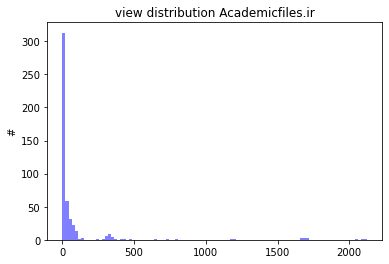

<Figure size 432x288 with 0 Axes>

In [19]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = pop
num_bins = 100
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.title('view distribution ' + WEB_SITE_NAME)
plt.ylabel('#')
plt.show()
plt.savefig(RESULTS + 'view_distribution_' + WEB_SITE_NAME + '.png', dpi=400)

In [20]:
len(item_content_map)

423

In [21]:
def a(s):
    r = []
    for i in range(len(s)-250):
        r.append(np.array(s[i:i+250]).mean())
    return r

In [23]:
for i in range(423):
    if not i%10:
        print(i, pop[i])

0 2122
10 1184
20 343
30 322
40 146
50 90
60 80
70 71
80 62
90 55
100 47
110 42
120 37
130 32
140 29
150 26
160 24
170 22
180 20
190 18
200 16
210 15
220 15
230 13
240 12
250 11
260 10
270 9
280 8
290 7
300 7
310 6
320 5
330 5
340 5
350 4
360 4
370 3
380 3
390 3
400 3
410 2
420 2


on production content based

In [ ]:
#chetor 3235
# recommending_items = item[:3235]#100=2403
#paroshat
recommending_items = item[:700]

In [ ]:
item_content_map_production = {}
for i, j in item_content_map.items():
    if i in recommending_items:
        item_content_map_production[i] = j

In [ ]:
ind_production_c, annoy_distances_c, duration_c = get_annoy_results_cp(item_content_map_production, item_content_map, number_of_neighbours = 11, AI = 300)
ind_production_c1 = [] 
for i in ind_production_c:
    ind_production_c1.append(i[1:])
ind_production_c1 = np.array(list((np.array(ind_production_c1)).flatten()))


In [ ]:
res_prod = []
for i in item:
    res_prod.append(np.equal(ind_production_c1, i).sum())

In [ ]:
plt.plot(a(res_prod))

other algorithms

In [ ]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 11)
ind2 = []
for i in ind:
    ind2.append(i[1:])
ind2 = np.array(list((np.array(ind2)).flatten()))
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())
len(res)

In [ ]:
plt.plot(a(res))

In [ ]:
annoy_indices_c, annoy_distances_c, duration_c = get_annoy_results_c(item_content_map, number_of_neighbours = 11, AI = 300)
ind3 = [] 
for i in annoy_indices_c:
    ind3.append(i[1:])
ind3 = np.array(list((np.array(ind3)).flatten()))
res2 = []
for i in item:
    res2.append(np.equal(ind3, i).sum())

In [ ]:
res = np.array(res)
res2 = np.array(res2)
res_prod = np.array(res_prod)

In [ ]:
content = []
colab = []
prod = []

content.append(np.mean(res2[50:100]))
colab.append(np.mean(res[50:100])+6)
prod.append(np.mean(res_prod[50:100]))
             
content.append(np.mean(res2[100:300]))
colab.append(np.mean(res[100:300]))
prod.append(np.mean(res_prod[100:300]))
             
content.append(np.mean(res2[300:700]))
colab.append(np.mean(res[300:700]))
prod.append(np.mean(res_prod[300:700]))

content.append(np.mean(res2[700:1500]))
colab.append(np.mean(res[700:1500]))
prod.append(np.mean(res_prod[700:1500]))

content.append(np.mean(res2[1500:2500]))
colab.append(np.mean(res[1500:2500]))
prod.append(np.mean(res_prod[1500:2500]))


content.append(np.mean(res2[2500:]))
colab.append(np.mean(res[2500:]))
prod.append(np.mean(res_prod[2500:]))

In [ ]:
labels = ['> 500', '100-500', '50-100', '10-50', '5-10', '< 5']
x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots(figsize=(9, 7))

rects1 = ax.bar(x, colab, width, label='CF')
rects2 = ax.bar(x +width, content, width, label='CB')
rects3 = ax.bar(x - width, prod, width, label='CB (production)')
ax.set_title('Popularity bias w.r.t Algorithm - ' + WEB_SITE_NAME)
ax.set_ylabel('Mean recommendation times')
ax.set_xlabel('# views')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


fig.tight_layout()
plt.savefig(RESULTS + 'popularity_bias_w.r.t._alg_' + WEB_SITE_NAME + '.png', dpi=400)
plt.show()

In [ ]:
content

In [ ]:
colab

In [ ]:
prod

## percentage of depricated pages recommended - pop after 6252 is depricated

In [ ]:
cb_deprecated = np.sum(res2[6252:])/np.sum(res2)*100
cb_deprecated

In [ ]:
cf_deprecated = np.sum(res[6252:])/np.sum(res)*100
cf_deprecated

In [ ]:
cbp_deprecated = np.sum(res_prod[6252:])/np.sum(res)*100
cbp_deprecated

In [ ]:
x = ['CB', 'CF', 'CB (production)']
y = [np.sum(res2[-500:])/np.sum(res2)*100,np.sum(res[-500:])/np.sum(res)*100, 0.00]

fig = plt.figure(figsize = (8, 5)) 
  
# creating the bar plot 
rects = plt.bar(x, y, color ='maroon', width = 0.3) 
plt.xlabel("Algorithm")  
plt.xlabel("% Deprecated pages")  
plt.title("% Deprecated pages w.r.t Algorithm - " + WEB_SITE_NAME)

plt.ylim(0,20)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)
plt.savefig(RESULTS + 'deprecated_alg_' + WEB_SITE_NAME + '.png', dpi=400)
plt.show() 

Coverage

In [ ]:
coverage_prod = np.unique(ind_production_c1).shape[0]/len(item)
coverage_prod

In [ ]:
coverage_CB = np.unique(ind3).shape[0]/len(item)
coverage_CB

In [ ]:
coverage_CF = np.unique(ind2).shape[0]/len(item)
coverage_CF

In [ ]:
x = ['CB', 'CF', 'CB (production)']
y = [coverage_CB, coverage_CF, coverage_prod]

fig = plt.figure(figsize = (8, 5))
  
# creating the bar plot 
rects = plt.bar(x, y, color ='maroon', width = 0.3) 
plt.xlabel("Algorithm") 
plt.xlabel("% Coverage")
plt.title("Coverage w.r.t Algorithm - " + WEB_SITE_NAME)

plt.ylim(0,1)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig(RESULTS + 'coverage_alg_' + WEB_SITE_NAME + '.png', dpi=400)
autolabel(rects)
plt.show()